In [275]:
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

In [276]:
dataset = pd.read_csv("../circles.dat", sep=" ", header=None)
dataset.columns = ["x1", "x2", "label"]
dataset.head()

,x1,x2,label
0,7.070786,4.318179,0
1,6.497705,11.174172,1
2,10.677792,4.017715,0
3,15.903207,5.782562,0
4,13.466723,-0.429226,1


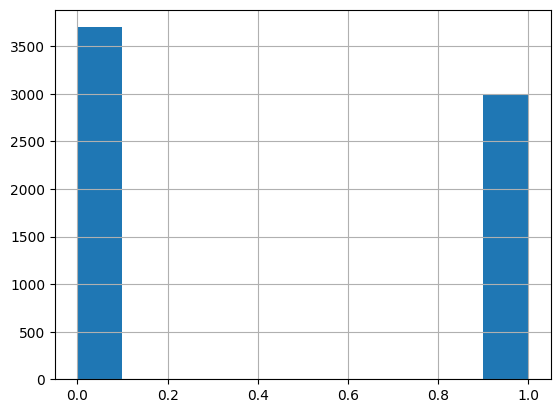

In [277]:
dataset["label"].hist()
plt.show()

In [278]:
dataset.describe()

,x1,x2,label
count,6700.000000,6700.000000,6700.000000
mean,5.262059,7.414891,0.447761
std,5.552721,4.966354,0.497301
min,-2.733407,-0.706078,0.000000
25%,0.620816,3.107090,0.000000
50%,3.527408,7.665652,0.000000
75%,9.346641,11.271289,1.000000
max,17.424482,17.403726,1.000000


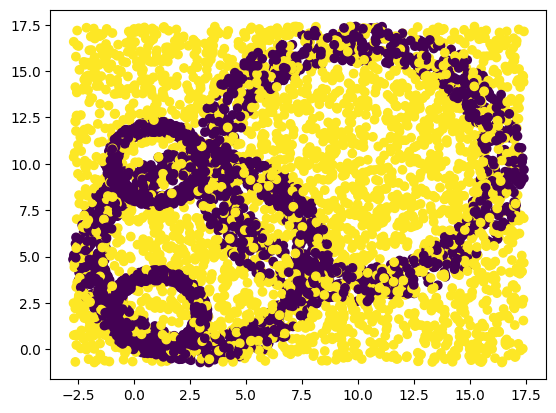

In [279]:
plt.scatter(dataset["x1"], dataset["x2"], c=dataset["label"])
plt.show()

array([[<Axes: title={'center': 'x1'}>, <Axes: title={'center': 'x2'}>]],
      dtype=object)

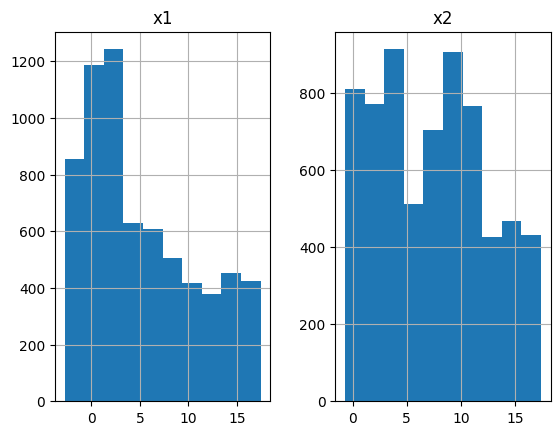

In [280]:
dataset[["x1", "x2"]].hist()

In [281]:
scaler = StandardScaler()
scale_dataset = scaler.fit_transform(dataset)
scale_dataset = pd.DataFrame(scale_dataset, columns=dataset.columns)
scale_dataset.head()

,x1,x2,label
0,0.325761,-0.623585,-0.900450
1,0.222546,0.757007,1.110555
2,0.975402,-0.684089,-0.900450
3,1.916527,-0.328702,-0.900450
4,1.477704,-1.579570,1.110555


In [311]:
class ModelByNeZorinEgor(nn.Module):
    def __init__(
            self,
            in_features: int, 
            out_features: int,
            *args, 
            **kwargs
    ) -> None:
        super().__init__(*args, **kwargs)
        self.linear1 = nn.Linear(in_features=in_features, out_features=16)
        self.linear2 = nn.Linear(in_features=16, out_features=32)
        self.linear3 = nn.Linear(in_features=32, out_features=32)
        self.linear4 = nn.Linear(in_features=32, out_features=out_features)
        self.act = nn.ReLU()
        self.final_act = nn.Sigmoid()

    def forward(self, x):
        x = self.act(self.linear1(x))
        x = self.act(self.linear2(x))
        x = self.act(self.linear3(x))
        out = self.final_act(self.linear4(x))
        return out


lr = 1e-2

model = ModelByNeZorinEgor(in_features=2, out_features=1)
optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)
loss_fn = nn.BCELoss()

In [312]:
# делим выборку, пока что в pandas, так проще
X_train, X_test, y_train, y_test = train_test_split(scale_dataset[["x1", "x2"]], dataset["label"], train_size=0.7, random_state=42)
# переводим в torch.Tensor type
# https://www.geeksforgeeks.org/deep-learning/understanding-pytorch-learning-rate-scheduling/?ysclid=mgxsbuphdz82548714
X_train = torch.FloatTensor(X_train.to_numpy())
y_train = torch.FloatTensor(y_train.to_numpy())

X_test = torch.FloatTensor(X_test.to_numpy())
y_test = torch.FloatTensor(y_test.to_numpy())

train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
test_dataset = torch.utils.data.TensorDataset(X_test, y_test)

batch_size =32
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [313]:
def accuracy(y_pred: torch.Tensor, y_true: torch.Tensor):
    y_pred, y_true = np.round(y_pred.detach().numpy()), y_true.detach().numpy() # type: ignore
    return sum(y_pred==y_true)/len(y_pred)

In [314]:
epochs = 130

max_acc = -float('inf')

train_losses = []
train_accuracy = []
test_accuracy = [] 

for i in range(epochs):
    # метрики в рантайме
    train_running_accuracy = []
    train_running_loss = []
    # обучение
    model.train()
    train_progressbar = tqdm(train_loader)
    for x, y in train_progressbar:
        optimizer.zero_grad()

        y_pred = model(x).squeeze()
        loss = loss_fn(y_pred, y)
        loss.backward()
        optimizer.step()

        acc = accuracy(y_pred=y_pred, y_true=y)
        train_running_accuracy.append(acc)
        train_running_loss.append(loss.item())

        train_progressbar.set_description(f"TRAIN epohc [{i+1}/{epochs}] accuracy={acc:.2f} loss={loss.item():.2f}")
    # собираем метрики
    train_accuracy.append(np.mean(train_running_accuracy))
    train_losses.append(np.mean(train_running_loss))

    # валидация
    with torch.no_grad():
        test_running_accuracy = []
        model.eval()
        test_progressbar = tqdm(test_loader)
        for x, y in test_progressbar:
            y_pred = model(x).squeeze()
            acc = accuracy(y_pred=y_pred, y_true=y)
            test_running_accuracy.append(acc)

            test_progressbar.set_description(f"TRAIN epohc [{i+1}/{epochs}] accuracy={acc:.2f}")

            # сохраняем лучшую модельку
            if acc > max_acc:
                max_acc = acc
                torch.save(model.state_dict(), "./best.pt")
        test_accuracy.append(np.mean(test_running_accuracy))


TRAIN epohc [130/130] accuracy=0.88: 100%|██████████| 63/63 [00:00<00:00, 231.63it/s]


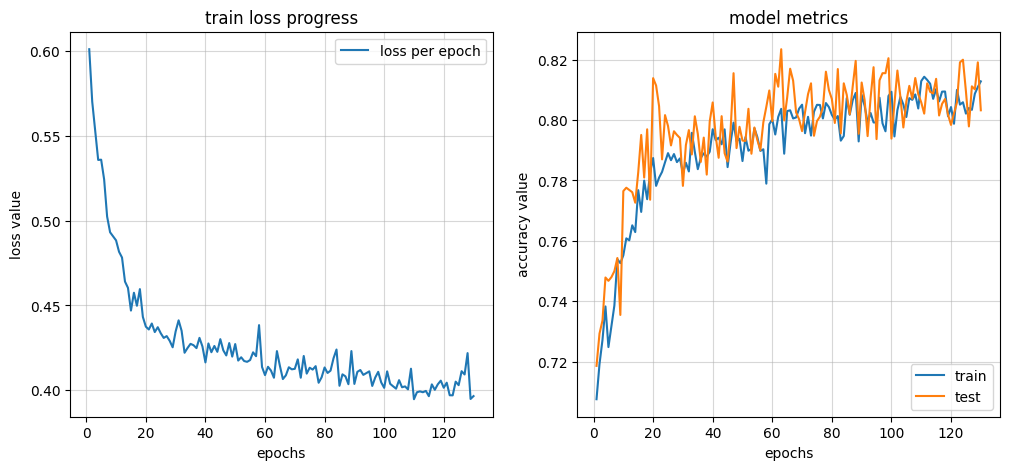

In [315]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
# loss
ax[0].plot([i for i in range(1, epochs+1)], train_losses, label="loss per epoch")
ax[0].grid(alpha=0.5)
ax[0].legend()
ax[0].set_xlabel("epochs")
ax[0].set_ylabel("loss value")
ax[0].set_title("train loss progress")
# метрики
ax[1].plot([i for i in range(1, epochs+1)], train_accuracy, label="train")
ax[1].plot([i for i in range(1, epochs+1)], test_accuracy, label="test")
ax[1].grid(alpha=0.5)
ax[1].legend()
ax[1].set_xlabel("epochs")
ax[1].set_ylabel("accuracy value")
ax[1].set_title("model metrics")
plt.show()

Судя по графикам видно, что loss не плохо так снизился, а метрика accuracy лостигла неплохих результатов для бинарного классификатора

In [316]:
model = ModelByNeZorinEgor(in_features=2, out_features=1)
model.load_state_dict(torch.load("./best.pt"))
predict  = model(torch.FloatTensor(scale_dataset[["x1", "x2"]].to_numpy()))

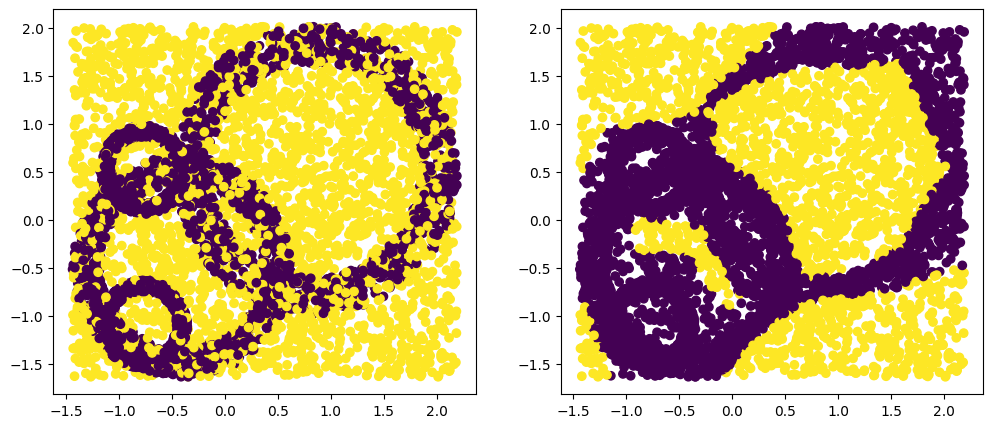

In [317]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].scatter(scale_dataset["x1"], scale_dataset["x2"], c=dataset["label"])
ax[1].scatter(scale_dataset["x1"], scale_dataset["x2"], c=torch.round(predict.detach()))
plt.show()